In [1]:
# Explore

In [150]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import math

from lime import lime_image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

import input_data
import models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
def sine(f0, fs=16000, phase=0, dur=0.5):    
    t = np.arange(dur*fs)
    sinusoid = np.sin(2*np.pi*t*(f0/fs) + phase)
    noise = np.random.normal(0.0,1.0,len(t))
    sound = sinusoid + noise
    return sound

    
import keras
import models_keras
import librosa


def test_data(frequencies, n_mels, N=100, fs=16000):
    np.random.seed(1)
    
    features = []
    y = []
    for cl, f in enumerate(frequencies):
        for n in range(N):
            freq = f + np.random.normal(0.0, 50, 1)[0]
            audio = sine(freq, phase=np.random.normal(0.0, 1.0, 1)[0])
            feature = librosa.feature.melspectrogram(audio, sr=fs, n_mels=n_mels)
            feature = np.log(feature+1e-12)

            features.append(feature)
            y.append(cl)

    features = np.stack(features)
    features = np.expand_dims(features, axis=-1)
    y = np.stack(y)
    return features, y
    
    
n_mels = 32
input_frames = 16
frequencies = [ 220, 1000, 4000, ]

X, cls = test_data(frequencies, n_mels)
y = keras.utils.to_categorical(cls)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)
    
model = models_keras.build_tiny_conv(input_frames=input_frames, input_bins=n_mels, n_classes=len(frequencies))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.3)

import sklearn.metrics
sklearn.metrics.accuracy_score(y_test, model.predict(X_test) > 0.5)

Train on 147 samples, validate on 63 samples
Epoch 1/20


InvalidArgumentError: Tensor dense_1_target:0, specified in either feed_devices or fetch_devices was not found in the Graph

In [136]:
sine_model = model

# LIME expects RGB images
def spec_to_rgb(spec):
    assert len(spec.shape) == 3, spec.shape
    assert spec.shape[2] == 1, spec.shape
    
    s = (spec.shape[0], spec.shape[1], 3)
    rgb = np.ndarray(shape=s, dtype=spec.dtype)
    rgb[:,:, 0] = spec[:,:,0]/3
    rgb[:,:, 1] = spec[:,:,0]/3
    rgb[:,:, 2] = spec[:,:,0]/3
    return rgb
    
def spec_from_rgb(rgb):
    assert len(rgb.shape) == 3, rgb.shape
    assert rgb.shape[2] == 3, rgb.shape
    
    r, g, b = rgb[:,:,0],rgb[:,:,1], rgb[:,:,2]
    spec = r + g + b
    spec = np.expand_dims(spec, axis=-1)
    return spec
    
def sine_image(inputs):
    images = [ spec_to_rgb(inp) for inp in inputs ]
    return np.array(images)

def sine_predict(images):
    specs = np.array([ spec_from_rgb(img) for img in images ])
    predictions = sine_model.predict_proba(specs)
    #print('p', predictions)
    return predictions

def explain(inp, expected_label, image_fn, predict_fn, ax=None):
    images = image_fn([inp])
    p = predict_fn(images)
    image = images[0]

    predicted = np.argmax(p[0])
    score = p[0][predicted]
    
    explainer = lime_image.LimeImageExplainer()
    start_time = time.time()
    
    explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0)
    explanation_time = time.time() - start_time
    
    from skimage.segmentation import mark_boundaries
    
    # TODO: plot frequency and time on axis
    temp, mask = explanation.get_image_and_mask(predicted, positive_only=False,
                                                num_features=None, hide_rest=False,
                                                min_weight=0.1)
    
    if not ax:
        fig = plt.figure(figsize=(6,20))
        ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(temp / 2 + 0.5, mask), aspect=1/6)
    ax.set_title("T: {} P: {}, score={}".format(expected_label, predicted, score))

for sample in range(0, 10):
    explain(X_test[sample], np.argmax(y_test[sample]), image_fn=sine_image, predict_fn=sine_predict)
    

InvalidArgumentError: You must feed a value for placeholder tensor 'conv2d_12_input' with dtype float and shape [?,16,32,1]
	 [[{{node conv2d_12_input}} = Placeholder[dtype=DT_FLOAT, shape=[?,16,32,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [76]:
X_test[0].shape

(16, 32, 1)

In [153]:

tf.reset_default_graph()

def setup(sample_rate=16000, clip_duration_ms=1000.0,
            window_size_ms=30.0, window_stride_ms=10.0,
            feature_bin_count=40, preprocess='logmel', n_classes=12,
            silence = 10.0, unknown = 10.0,
            testing = 10.0, validation = 10.0):

    m = models.prepare_model_settings(n_classes, sample_rate,
                                      clip_duration_ms, window_size_ms, window_stride_ms,
                                      feature_bin_count, preprocess)
    
    wanted_words = 'yes,no,up,down,left,right,on,off,stop,go'.split(',')
    p = input_data.AudioProcessor(None, '../../data/speech_dataset/',
                                silence, unknown, wanted_words,
                                validation, testing, m, None)
    p.wanted_words = wanted_words
    return m, p

model_settings, audio_processor = setup(feature_bin_count=32)


def wav_to_features(input_wav):
    results = audio_processor.get_features_for_wav(input_wav, model_settings, session)
    features = results[0]
    return features

#f = wav_to_features('../../data/speech_dataset/nine/122c5aa7_nohash_0.wav')
#f.shape

In [154]:
image_size = (98, model_settings['fingerprint_width'], 1)
f_size = (None, 98, model_settings['fingerprint_width'], 1)

processed_images = tf.placeholder(tf.float32, shape=f_size)
model = models.create_model(processed_images, model_settings,
                            model_architecture='low_latency_conv', is_training=False)

session = tf.Session()

def transform_img_fn(path_list):
    out = []
    for f in path_list:
        image = wav_to_features(f).squeeze(axis=0)
        image = np.expand_dims(image, axis=-1)
        rgb = spec_to_rgb(image)
        i = tf.convert_to_tensor(rgb) 
        out.append(i)
    return session.run([out])[0]

#tf.get_variable_scope().reuse_variables()

checkpoint = '../../data/speech-logmel32/low_latency_conv.ckpt-26000'

models.load_variables_from_checkpoint(session, checkpoint)
saver = tf.train.Saver(tf.global_variables())
saver.restore(session, checkpoint)

probabilities = tf.nn.softmax(model, name='labels_softmax')
def predict_fn(images):
    images = [ spec_from_rgb(img) for img in images ]
    return session.run(probabilities, feed_dict={processed_images: images})


p = predict_fn(transform_img_fn(['../../data/speech_dataset/left/122c5aa7_nohash_0.wav']))
p

INFO:tensorflow:Restoring parameters from ../../data/speech-logmel32/low_latency_conv.ckpt-26000
INFO:tensorflow:Restoring parameters from ../../data/speech-logmel32/low_latency_conv.ckpt-26000


array([[7.7495160e-14, 6.3936449e-07, 1.4436684e-03, 1.4591980e-08,
        2.0835017e-08, 1.0356598e-09, 9.9853957e-01, 1.6150674e-05,
        2.3668862e-12, 6.8114727e-09, 3.4389731e-09, 2.7189045e-10]],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


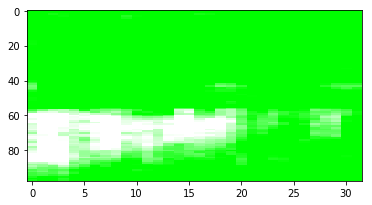

In [161]:

def explain(filepath, expected_label, ax=None):
    images = transform_img_fn([filepath])
    p = predict_fn(images)
    image = images[0]

    predicted = np.argmax(p[0])
    score = p[0][predicted]
    label = audio_processor.words_list[predicted]
    
    explainer = lime_image.LimeImageExplainer()
    start_time = time.time()
    
    explanation = explainer.explain_instance(image, predict_fn, top_labels=5,
                                             hide_color=math.log(1e-6), num_samples=1000)
    explanation_time = time.time() - start_time
    
    from skimage.segmentation import mark_boundaries
    
    # TODO: plot frequency and time on axis
    temp, mask = explanation.get_image_and_mask(predicted, positive_only=False, hide_rest=False, min_weight=0.1)
    
    if not ax:
        fig = plt.figure(figsize=(6,20))
        ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(temp / 2 + 0.5, mask), aspect=1/6)
    
explain('../../data/speech_dataset/down/122c5aa7_nohash_1.wav', 'down')
    

In [156]:
# return Pandas.DataFrame
def get_samples(audio_processor):
    
    data = {
        'split': [],
        'file': [],
        'label': [],
        'included': [],
    }
    
    for dataset, files in audio_processor.data_index.items():
        for sample in files:
            label = sample['label']
            data['included'].append(label in audio_processor.wanted_words)
            data['split'].append(dataset)
            data['label'].append(label)
            data['file'].append(sample['file'])
                  
    return pandas.DataFrame(data)

all_samples = get_samples(audio_processor)
samples = all_samples[all_samples.included == True]
print('labels', samples.label.unique(), len(samples.label.unique()))
samples.head(3)

labels ['go' 'up' 'no' 'down' 'yes' 'stop' 'off' 'right' 'left' 'on'] 10


,split,file,label,included
2,validation,../../data/speech_dataset/go/099d52ad_nohash_2...,go,True
4,validation,../../data/speech_dataset/up/026290a7_nohash_0...,up,True
5,validation,../../data/speech_dataset/no/c2d15ea5_nohash_0...,no,True


go


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

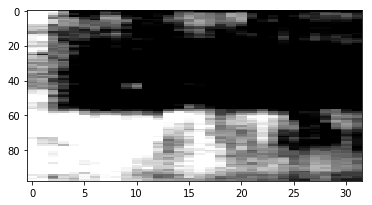

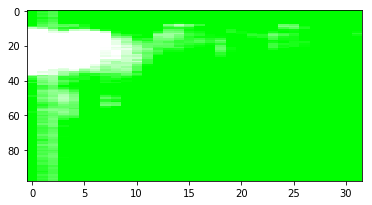

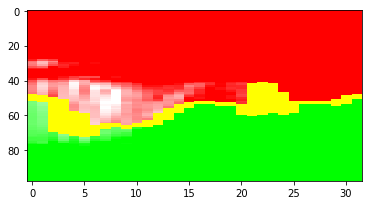

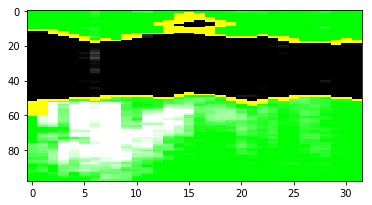

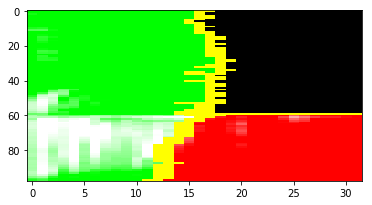

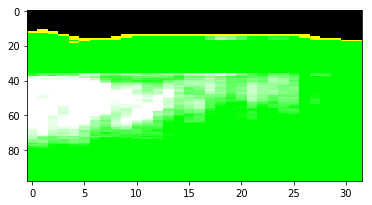

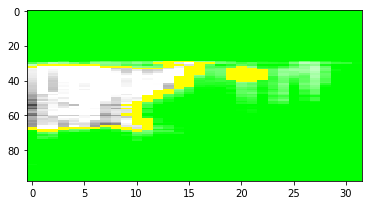

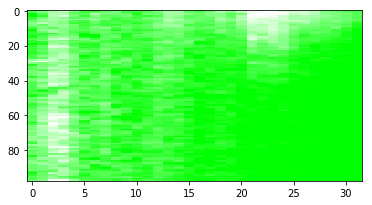

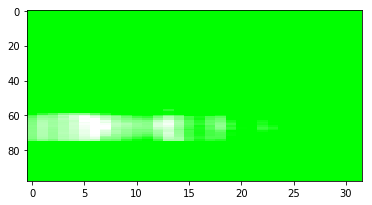

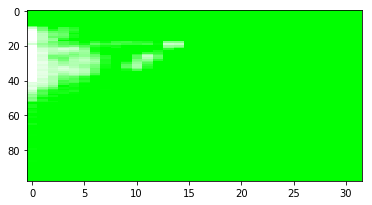

In [162]:
for label in samples.label.unique()[:1]:
    print(label)
    test = samples[samples.label == label].sample(10)
    for t in test.iterrows():
        _, data = t
        explain(data.file, data.label)